In [1]:
# import packages
import numpy as np
import pandas as pd

import re
from datetime import datetime
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import mca
%matplotlib inline

In [2]:
# read in data
df = pd.read_csv('./combined.csv')

In [3]:
#get info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23735 entries, 0 to 23734
Data columns (total 30 columns):
Unnamed: 0              23735 non-null int64
ACCIDENTDATE            23735 non-null object
AOTACTUALMILEPOINT      23735 non-null float64
AOTROUTE                23735 non-null object
Animal                  23735 non-null object
CITYORTOWN              23735 non-null object
DIROFCOLLI              23735 non-null object
DayNight                23735 non-null object
HOWMAPPED               23735 non-null object
INTERSECTIONWITH        23735 non-null object
Impairment              23735 non-null object
InjuryType              23735 non-null object
Involving               23735 non-null object
LAT_DD                  23735 non-null float64
LOCALID                 23735 non-null object
LOC_ERROR               23735 non-null object
LONG_DD                 23735 non-null float64
LRSNUMBER               23735 non-null object
NonReportableAddress    23735 non-null object
REPORTINGAGENCY

I will now go through each individual variable that is analyzeable and will look at ways to manually reduce dimensions.

In [4]:
# frequency analyis for AOTRoute
df['AOTROUTE'].value_counts().head(20)

Unknown           2640
US-7              1811
I-89              1690
I-91              1086
US-2               963
US-5               937
VT-15              768
VT-100             604
VT-9               401
VT-2A              341
US-4               338
VT-30              254
VT-11              241
VT-14              227
VT-116             208
US-302             190
VT-105             180
VT-12              174
VT-7A              168
ALTERNATE US-7     160
Name: AOTROUTE, dtype: int64

We will keep the ten routes with highest crash volume. These routes have over 300 crashes over the four years studied, which averages out to about one crash every three days. 

In [5]:
# scale down
AOTRoute = pd.Series(np.where(((df['AOTROUTE'] != 'US-7')&(df['AOTROUTE'] != 'I-89')&
                            (df['AOTROUTE'] != 'I-91')&(df['AOTROUTE'] != 'US-2')&
                            (df['AOTROUTE'] != 'US-5')&(df['AOTROUTE'] != 'VT-15')&
                            (df['AOTROUTE'] != 'VT-100')&(df['AOTROUTE'] != 'VT-9')&
                            (df['AOTROUTE'] != 'VT-2A')&(df['AOTROUTE'] != 'US-4')),'Other',df.AOTROUTE))
AOTRoute = pd.get_dummies(AOTRoute)

In [6]:
# get dummies for animal --> get "none" column for yes/no
animal = pd.get_dummies(df['Animal'])['None/Other']
#recode 0 to 1 and 1 to 0; this way a 1 is yes
animal = pd.Series(np.where(np.array(animal)==0,1,0))

In [7]:
# frequency analyis for CITYORTOWN
df['CITYORTOWN'].value_counts().head(20)

Burlington          3000
Brattleboro         1332
South Burlington    1264
Essex               1099
Bennington          1011
Williston            757
Colchester           577
Springfield          575
Hartford             520
Milton               439
Middlebury           398
Winooski City        351
Stowe                345
Rutland City         279
Montpelier           272
Barre City           242
Berlin               223
Richmond             218
Morristown           216
Shelburne            211
Name: CITYORTOWN, dtype: int64

In [8]:
# scale down
city_town = pd.Series(np.where(((df['CITYORTOWN'] != 'Burlington')&(df['CITYORTOWN'] != 'Brattleboro')&
                            (df['CITYORTOWN'] != 'South Burlington')&(df['CITYORTOWN'] != 'Essex')&
                            (df['CITYORTOWN'] != 'Bennington')&(df['CITYORTOWN'] != 'Williston')&
                            (df['CITYORTOWN'] != 'Colchester')&(df['CITYORTOWN'] != 'Springfield')&
                            (df['CITYORTOWN'] != 'Hartford')&(df['CITYORTOWN'] != 'Milton')),'Other',df.CITYORTOWN))
city_town = pd.get_dummies(city_town)

In [9]:
# DayNight --> save "night" case only as yes/no
night=pd.get_dummies(df['DayNight'])['Night']

In [10]:
# Impairment --> get "none" column for yes/no
impairment=pd.get_dummies(df['Impairment'])['None']
#recode 0 to 1 and 1 to 0; this way a 1 is yes
impairment = pd.Series(np.where(np.array(impairment)==0,1,0))

In [11]:
# get dummies for Injury
injury = pd.get_dummies(df['InjuryType'])
# remove "property damage only" which is the null case
injury = injury.drop(columns=['Property Damage Only'])

In [12]:
# get dummies for Involving
involving = pd.get_dummies(df['Involving'])
# remove "none" column which is the null case
involving = involving.drop(columns = ['None'])

In [13]:
# Get dummies for road condition
roadcondition = pd.get_dummies(df['RoadCondition'])
# drop "none" column which is the null case, unreported situations, and the surface condition; will add in later
roadcondition = roadcondition.drop(columns=['None', 'Other - Explain in Narrative', 'Not reported', 'Unknown',
                                            'Road Surface Condition(wet, icy, snow, slush, etc)'])

In [14]:
# get dummies for surface condition
surfacecondition = pd.get_dummies(df['SurfaceCondition'])
# drop "dry" column which is the null case along with unreported situations
surfacecondition = surfacecondition.drop(columns=['Dry', 'Not Reported', 'Other - Explain in Narrative', 'Unknown'])

In [15]:
# get dummies for weather
weather = pd.get_dummies(df['Weather'])
# drop "clear" column which is the null case along with unreported situations
weather = weather.drop(columns=['Clear', 'Unknown'])

In [16]:
# get accident dates
datetime = df['ACCIDENTDATE']
months = '' # new string
# use loop to extract month from date string
for i in range(len(datetime)):
    match = re.search(r'\d{4}-\d{2}-\d{2}', datetime[i]).group()
    months += match[5:7] + ','
# remove last extraneous comma from loop
months = months[:-1]
# split comma separated string
months = months.split(",")
# convert to DataFrame
months = pd.Series(months)

In [17]:
# determine season
seasons = ""
for i in range(len(months)):
    if months[i]=='12':
        seasons += 'Winter' + ','
    if months[i]=='01':
        seasons += 'Winter' + ','
    if months[i]=='02':
        seasons += 'Winter' + ','
    if months[i]=='03':
        seasons += 'Spring' + ','
    if months[i]=='04':
        seasons += 'Spring' + ','
    if months[i]=='05':
        seasons += 'Spring' + ','
    if months[i]=='06':
        seasons += 'Summer' + ','
    if months[i]=='07':
        seasons += 'Summer' + ','
    if months[i]=='08':
        seasons += 'Summer' + ','
    if months[i]=='09':
        seasons += 'Fall' + ','
    if months[i]=='10':
        seasons += 'Fall' + ','
    if months[i]=='11':
        seasons += 'Fall' + ','
# remove last extraneous comma from loop
seasons = seasons[:-1]
# split comma separated string
seasons = seasons.split(",")
# convert to DataFrame
seasons = pd.Series(seasons)
seasons = pd.get_dummies(seasons)

In [20]:
# Build data frame for PCA
pca_df = pd.concat([animal, night, impairment], axis=1)
pca_df.columns=['Animal', 'Night', 'Impairment']
pca_df = pd.concat([pca_df, AOTRoute, city_town, injury, involving, roadcondition, surfacecondition, weather, seasons],
                   axis=1, sort=False)
pca_df

,Animal,Night,Impairment,I-89,I-91,Other,US-2,US-4,US-5,US-7,...,Water (standing / moving),Wet,Cloudy,Freezing Precipitation,Rain,Wind,Fall,Spring,Summer,Winter
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,0,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23730,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
23731,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
23732,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
23733,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [19]:
# look at dataframe
pca_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23735 entries, 0 to 23734
Data columns (total 53 columns):
Animal                                                      23735 non-null int64
Night                                                       23735 non-null uint8
Impairment                                                  23735 non-null int64
I-89                                                        23735 non-null uint8
I-91                                                        23735 non-null uint8
Other                                                       23735 non-null uint8
US-2                                                        23735 non-null uint8
US-4                                                        23735 non-null uint8
US-5                                                        23735 non-null uint8
US-7                                                        23735 non-null uint8
VT-100                                                      23735 non-null uint8


In [21]:
# do PCA with full 53 components
pca_full = PCA(n_components=53)
# fit model
pca_full.fit(pca_df)

PCA(copy=True, iterated_power='auto', n_components=53, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [22]:
# check to see how much variance each explains
var_full = pca_full.explained_variance_ratio_
print(var_full)

[1.13586997e-01 9.33288895e-02 8.67396215e-02 7.28148359e-02
 7.11896657e-02 5.97859841e-02 5.35663814e-02 4.73469993e-02
 4.34570080e-02 3.66629307e-02 3.23338166e-02 2.34544052e-02
 2.17046632e-02 1.85496145e-02 1.84320928e-02 1.72264064e-02
 1.50523531e-02 1.49078189e-02 1.33363546e-02 1.23754848e-02
 1.19120525e-02 1.15152770e-02 1.03840148e-02 9.06690636e-03
 8.85966188e-03 8.58032393e-03 8.29726164e-03 7.72202489e-03
 7.42732401e-03 7.14283675e-03 6.12930884e-03 5.40475095e-03
 4.50829849e-03 4.29271706e-03 3.92681362e-03 3.50857502e-03
 3.43854125e-03 1.97545959e-03 1.84671375e-03 1.76992515e-03
 1.30716131e-03 1.29243949e-03 8.57243619e-04 7.63171104e-04
 7.06621519e-04 6.68792106e-04 4.20571737e-04 2.31815923e-04
 1.22858047e-04 6.82146789e-05 4.23872256e-32 1.75696398e-32
 1.72573251e-32]


In [26]:
# see cumulative variance
var_full_cumul = np.cumsum(np.round(pca_full.explained_variance_ratio_, decimals=4)*100)

print(var_full_cumul)

[11.36 20.69 29.36 36.64 43.76 49.74 55.1  59.83 64.18 67.85 71.08 73.43
 75.6  77.45 79.29 81.01 82.52 84.01 85.34 86.58 87.77 88.92 89.96 90.87
 91.76 92.62 93.45 94.22 94.96 95.67 96.28 96.82 97.27 97.7  98.09 98.44
 98.78 98.98 99.16 99.34 99.47 99.6  99.69 99.77 99.84 99.91 99.95 99.97
 99.98 99.99 99.99 99.99 99.99]


Text(0, 0.5, 'Cumulative Variance Explained')

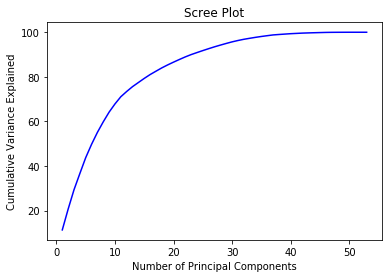

In [28]:
var1 = pd.DataFrame(var_full_cum, index=np.arange(1,54))
plt.plot(var1,color='blue')
plt.title('Scree Plot')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')

In [31]:
# choose 25 component solution
# Select the number of components
pca25 = PCA(n_components=25)
pca25.fit(pca_df)
data_pca25 = pca25.transform(pca_df)

# Convert the numpy array to pandas DataFrame
data_pca25 = pd.DataFrame(data_pca25)
data_pca25.columns = ["PC"+str(i) for i in range(1,26)]

# Show the head of the DataFrame
data_pca25.head(10)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25
0,0.289751,0.551971,1.040418,0.020205,-0.066119,-0.190895,-0.041640,-0.032236,-0.104010,-0.272467,...,-0.169972,-0.198459,0.019197,-0.347266,0.102071,-0.124232,0.003573,0.113358,-0.215096,0.106622
1,1.150400,-0.020052,0.543908,-0.011202,0.032345,-0.228632,-0.397663,-0.195933,0.155482,-0.127182,...,1.139216,-0.285385,-0.208069,-0.025130,0.129667,-0.104180,0.169337,-0.116612,0.029756,0.051710
2,0.709556,1.112919,-0.151310,0.144012,0.094778,0.840404,-0.437894,0.072118,0.147313,0.767876,...,-0.117109,-0.172342,-0.010539,-0.307206,-0.022461,-0.192634,-0.003112,0.147051,-0.260469,0.141654
3,0.154452,0.970143,0.008274,-0.088243,-0.122648,-0.200260,0.044939,0.023974,-0.056323,-0.287006,...,-0.110528,-0.106624,-0.003576,-0.265693,0.056703,-0.239206,-0.073810,0.184451,-0.179610,0.376615
4,0.574421,1.191070,-0.088385,-0.056149,0.121968,-0.078984,-0.622449,0.129965,0.314940,0.735596,...,-0.047267,-0.258615,0.085679,-0.146969,0.026412,-0.040401,-0.009336,-0.040065,0.164910,0.179612
5,0.887492,0.404161,-0.462436,-0.159185,-0.054826,-0.314029,-0.339636,-0.142235,0.094736,0.117443,...,-0.521177,0.044034,0.009565,-0.017787,-0.017880,0.081489,0.224116,-0.049703,-0.032665,-0.233796
6,1.109612,-0.002739,0.542835,-0.044109,0.012942,-0.257598,-0.434858,-0.176532,0.093971,0.027493,...,-0.477914,0.006395,-0.017007,-0.085014,0.013970,-0.050125,0.267606,-0.131950,-0.011499,-0.173796
7,0.574421,1.191070,-0.088385,-0.056149,0.121968,-0.078984,-0.622449,0.129965,0.314940,0.735596,...,-0.047267,-0.258615,0.085679,-0.146969,0.026412,-0.040401,-0.009336,-0.040065,0.164910,0.179612
8,1.151446,0.244212,-0.537833,-0.172316,0.049837,-0.200642,-0.542907,0.817021,0.545483,0.512337,...,-0.021085,-0.048048,-0.049007,-0.014397,-0.054872,0.011677,-0.041613,0.002171,0.028080,0.088414
9,0.121824,-1.093524,0.287383,0.833012,-0.343197,0.565040,-0.168034,0.551165,-0.013365,-0.191561,...,-0.035521,-0.111647,0.041999,-0.141998,-0.137984,0.135898,-0.046784,-0.001374,0.024042,0.012420


In [32]:
#correlation analysis
data_pca25.corr()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25
PC1,1.000000e+00,8.978939e-15,-1.217884e-13,-5.674302e-13,-9.743861e-14,-1.146310e-12,2.101969e-13,-2.630451e-12,-4.703191e-12,-4.485159e-12,...,-3.180261e-11,-4.885360e-10,2.542892e-11,-5.113579e-10,7.465116e-10,1.904353e-10,8.115937e-10,-1.776839e-09,2.365650e-09,-3.747405e-10
PC2,8.978939e-15,1.000000e+00,2.843823e-14,-1.530090e-13,-7.262343e-15,-3.909893e-13,3.341772e-13,-1.221352e-13,-1.134593e-12,4.253687e-13,...,-4.923570e-11,-6.131183e-11,1.046157e-11,-1.002308e-10,2.527943e-10,-2.286202e-10,6.044477e-10,-1.037652e-10,8.959387e-10,2.039467e-10
PC3,-1.217884e-13,2.843823e-14,1.000000e+00,1.150643e-12,2.994704e-13,1.880438e-12,1.081862e-12,8.576937e-12,1.031444e-11,1.804697e-11,...,-1.558425e-10,1.381651e-09,-3.625646e-11,1.243543e-09,-1.224084e-09,-1.956012e-09,4.652496e-10,5.687916e-09,-3.375057e-09,2.576813e-09
PC4,-5.674302e-13,-1.530090e-13,1.150643e-12,1.000000e+00,1.119331e-12,1.481670e-11,-4.241429e-12,2.944412e-11,5.799688e-11,4.651133e-11,...,6.300750e-10,5.692175e-09,-3.294686e-10,6.184863e-09,-9.669089e-09,-6.764228e-10,-1.242813e-08,1.999107e-08,-3.118497e-08,2.569673e-09
PC5,-9.743861e-14,-7.262343e-15,2.994704e-13,1.119331e-12,1.000000e+00,2.167921e-12,-1.591855e-13,5.745075e-12,9.357440e-12,1.028436e-11,...,2.114509e-11,1.026712e-09,-4.522629e-11,1.047000e-09,-1.425224e-09,-6.552958e-10,-1.235792e-09,3.859501e-09,-4.453093e-09,9.810120e-10
PC6,-1.146310e-12,-3.909893e-13,1.880438e-12,1.481670e-11,2.167921e-12,1.000000e+00,-1.108748e-11,5.645617e-11,1.197046e-10,8.349120e-11,...,1.645851e-09,1.127490e-08,-7.116710e-10,1.257312e-08,-2.056068e-08,9.407738e-10,-2.908757e-08,3.852984e-08,-6.707164e-08,2.757379e-09
PC7,2.101969e-13,3.341772e-13,1.081862e-12,-4.241429e-12,-1.591855e-13,-1.108748e-11,1.000000e+00,-8.881013e-13,-3.060381e-11,1.871485e-11,...,-1.513974e-09,-1.383436e-09,2.852015e-10,-2.624229e-09,7.232043e-09,-7.567273e-09,1.831855e-08,-1.234038e-09,2.595691e-08,7.487288e-09
PC8,-2.630451e-12,-1.221352e-13,8.576937e-12,2.944412e-11,5.745075e-12,5.645617e-11,-8.881013e-13,1.000000e+00,2.487451e-10,2.917111e-10,...,1.773087e-10,2.788988e-08,-1.194151e-09,2.788556e-08,-3.685415e-08,-2.009261e-08,-2.809138e-08,1.057823e-07,-1.133689e-07,3.060640e-08
PC9,-4.703191e-12,-1.134593e-12,1.031444e-11,5.799688e-11,9.357440e-12,1.197046e-10,-3.060381e-11,2.487451e-10,1.000000e+00,4.032917e-10,...,4.573931e-09,4.747723e-08,-2.665328e-09,5.097073e-08,-7.804649e-08,-9.724044e-09,-9.576935e-08,1.686142e-07,-2.503848e-07,2.638757e-08
PC10,-4.485159e-12,4.253687e-13,1.804697e-11,4.651133e-11,1.028436e-11,8.349120e-11,1.871485e-11,2.917111e-10,4.032917e-10,1.000000e+00,...,-2.605809e-09,4.920337e-08,-1.654921e-09,4.672724e-08,-5.454643e-08,-5.173747e-08,-1.631451e-08,1.942369e-07,-1.599112e-07,7.092522e-08
